# Step #1 Load the Data

In [57]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=date_start, end=date_today)

# Create a quick overview of the dataset
df

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\Flo\anaconda3\envs\tf\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\Flo\anaconda3\envs\tf\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Flo\anaconda3\envs\tf\lib\site-packages\multitasking\__init__.py", line 102, in _run_via_pool
    return callee(*args, **kwargs)
  File "C:\Users\Flo\anaconda3\envs\tf\lib\site-packages\yfinance\multi.py", line 169, in _download_one_threaded
    data = _download_one(ticker, start, end, auto_adjust, back_adjust,
  File "C:\Users\Flo\anaconda3\envs\tf\lib\site-packages\yfinance\multi.py", line 181, in _download_one
    return Ticker(ticker).history(period=period, interval=interval,
  File "C:\Users\Flo\anaconda3\envs\tf\lib\site-packages\yfinance\base.py", line 157, in history
    data = data.json()
  File "C:\Users\Flo\anaconda3\envs\tf\lib\site-packages\requests\models.py", line 900, 

KeyboardInterrupt: 

# Step #2 Exploring the Data

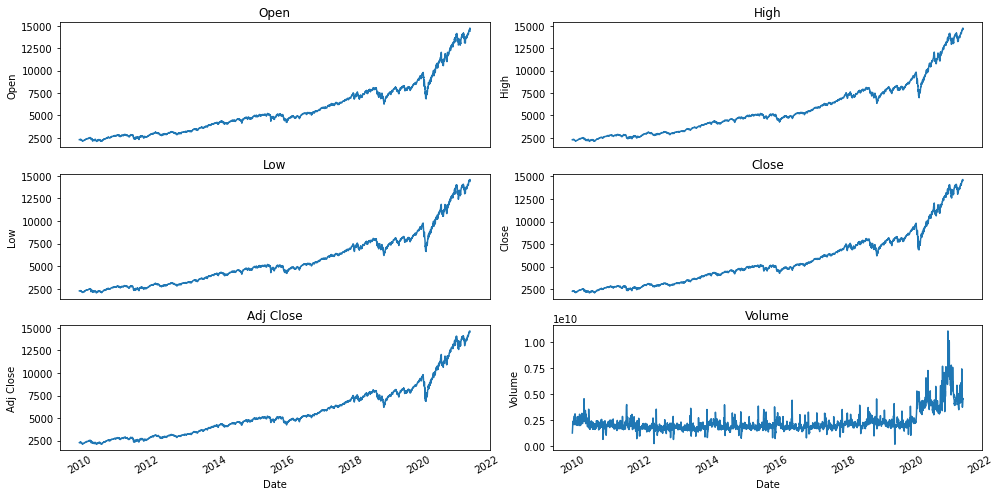

In [32]:
# Plot line charts
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [33]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Month'] = d.strftime("%m")
# train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
0,2292.919922,2293.590088,2269.110107,2269.149902,2269.149902,1237820000
1,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
3,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
4,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000


In [49]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
2894,14533.549805,14439.400391,14493.690430,14522.379883,4371620000,14522.379883
2895,14649.110352,14555.339844,14582.980469,14639.330078,3731730000,14639.330078
2896,14687.000000,14529.799805,14661.549805,14663.639648,4464780000,14663.639648
2897,14755.330078,14580.790039,14753.410156,14665.059570,4582030000,14665.059570
2898,14610.059570,14371.589844,14409.200195,14559.780273,4550600000,14559.780273


In [47]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2899, 5)


In [56]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 3
70 3
71 3
72 3
73 3
74 3
75 3
76 3
77 3
78 3
79 3
80 3
81 3
82 3
83 3
84 3
85 3
86 3
87 3
88 3
89 3
90 3
91 3
92 3
93 3
94 3
95 3
96 3
97 3
98 3
99 3
100 3
101 3
102 3
103 3
104 3
105 3
106 3
107 3
108 3
109 3
110 3
111 3
112 3
113 3
114 3
115 3
116 3
117 3
118 3
119 3
120 3
121 3
122 3
123 3
124 3
125 3
126 3
127 3
128 3
129 3
130 3
131 3
132 3
133 3
134 3
135 3
136 3
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
155 3
156 3
157 3
158 3
159 3
160 3
161 3
162 3
163 3
164 3
165 3
166 3
167 3
168 3
169 3
170 3
171 3
172 3
173 3
174 3
175 3
176 3
177 3
178 3
179 3
180 3
181 3
182 3
183 3
184 3
185 3
186 3
187 3
188 3
189 3
190 3
191 3
192 3
193 3
194 3
195 3
196 3
197 3
198 3
199 3
200 3
201 3
202 3
203 3
204 3
205 3
206 3
207 3
208 3
209 3
210 3
211 3
212 3
213 3
214 3
215 3
216 3
217 3
218 3
219 3
220 3
221 3
222 3
223 3
224 3


1523 3
1524 3
1525 3
1526 3
1527 3
1528 3
1529 3
1530 3
1531 3
1532 3
1533 3
1534 3
1535 3
1536 3
1537 3
1538 3
1539 3
1540 3
1541 3
1542 3
1543 3
1544 3
1545 3
1546 3
1547 3
1548 3
1549 3
1550 3
1551 3
1552 3
1553 3
1554 3
1555 3
1556 3
1557 3
1558 3
1559 3
1560 3
1561 3
1562 3
1563 3
1564 3
1565 3
1566 3
1567 3
1568 3
1569 3
1570 3
1571 3
1572 3
1573 3
1574 3
1575 3
1576 3
1577 3
1578 3
1579 3
1580 3
1581 3
1582 3
1583 3
1584 3
1585 3
1586 3
1587 3
1588 3
1589 3
1590 3
1591 3
1592 3
1593 3
1594 3
1595 3
1596 3
1597 3
1598 3
1599 3
1600 3
1601 3
1602 3
1603 3
1604 3
1605 3
1606 3
1607 3
1608 3
1609 3
1610 3
1611 3
1612 3
1613 3
1614 3
1615 3
1616 3
1617 3
1618 3
1619 3
1620 3
1621 3
1622 3
1623 3
1624 3
1625 3
1626 3
1627 3
1628 3
1629 3
1630 3
1631 3
1632 3
1633 3
1634 3
1635 3
1636 3
1637 3
1638 3
1639 3
1640 3
1641 3
1642 3
1643 3
1644 3
1645 3
1646 3
1647 3
1648 3
1649 3
1650 3
1651 3
1652 3
1653 3
1654 3
1655 3
1656 3
1657 3
1658 3
1659 3
1660 3
1661 3
1662 3
1663 3
1664 3
1665 3

(2270, 50, 5) (2270,)
(579, 50, 5) (579,)
0.022764164085701394
0.022764164085701394


# Step #4 Model Training

In [37]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [38]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/50
142/142 [==============================] - 6s 16ms/step - loss: 7.8478e-04 - val_loss: 5.2713e-04
Epoch 2/50
142/142 [==============================] - 1s 10ms/step - loss: 5.9848e-05 - val_loss: 4.8204e-04
Epoch 3/50
142/142 [==============================] - 1s 10ms/step - loss: 8.3924e-05 - val_loss: 7.9589e-04
Epoch 4/50
142/142 [==============================] - 1s 10ms/step - loss: 6.1263e-05 - val_loss: 5.9532e-04
Epoch 5/50
142/142 [==============================] - 1s 10ms/step - loss: 6.2161e-05 - val_loss: 0.0012
Epoch 6/50
142/142 [==============================] - 1s 10ms/step - loss: 5.3541e-05 - val_loss: 6.4819e-04
Epoch 7/50
142/142 [==============================] - 1s 10ms/step - loss: 6.1860e-05 - val_loss: 0.0015
Epoch 8/50
142/142 [==============================] - 1s 10ms/step - loss: 5.2474e-05 - val_loss: 5.3307e-04
Epoch 9/50
142/142 [==============================] - 1s 10ms/step - loss: 6.2798e-05 - val_loss: 5.9395e-04
Epoch 10/50
142/142 [======

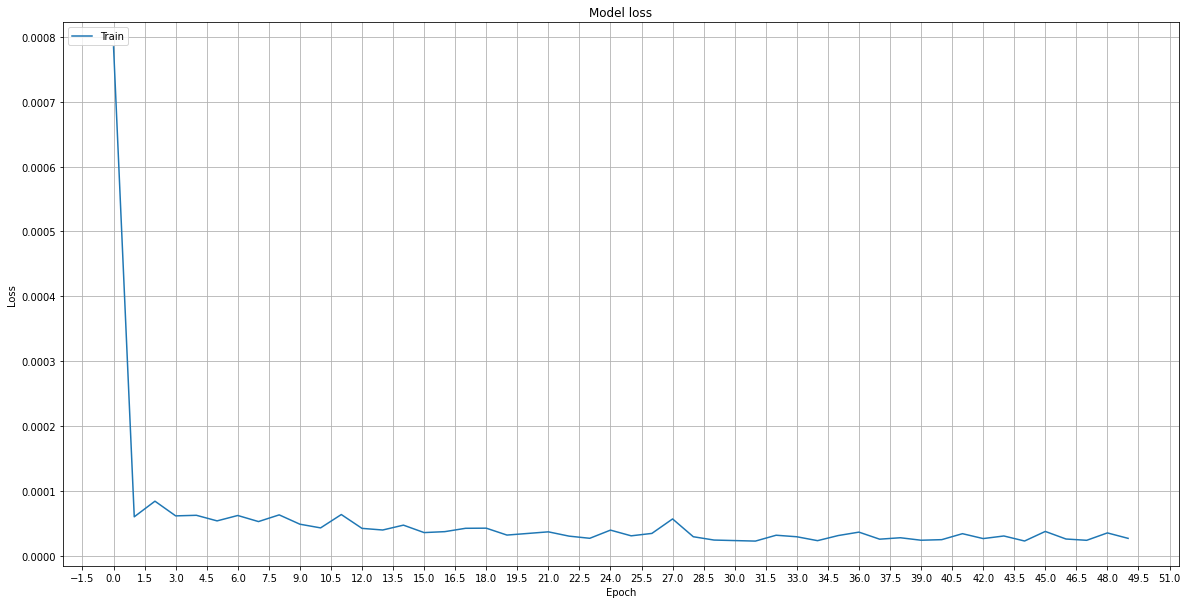

In [39]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [40]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 185.7
Mean Absolute Percentage Error (MAPE): 1.73 %
Median Absolute Percentage Error (MDAPE): 1.36 %


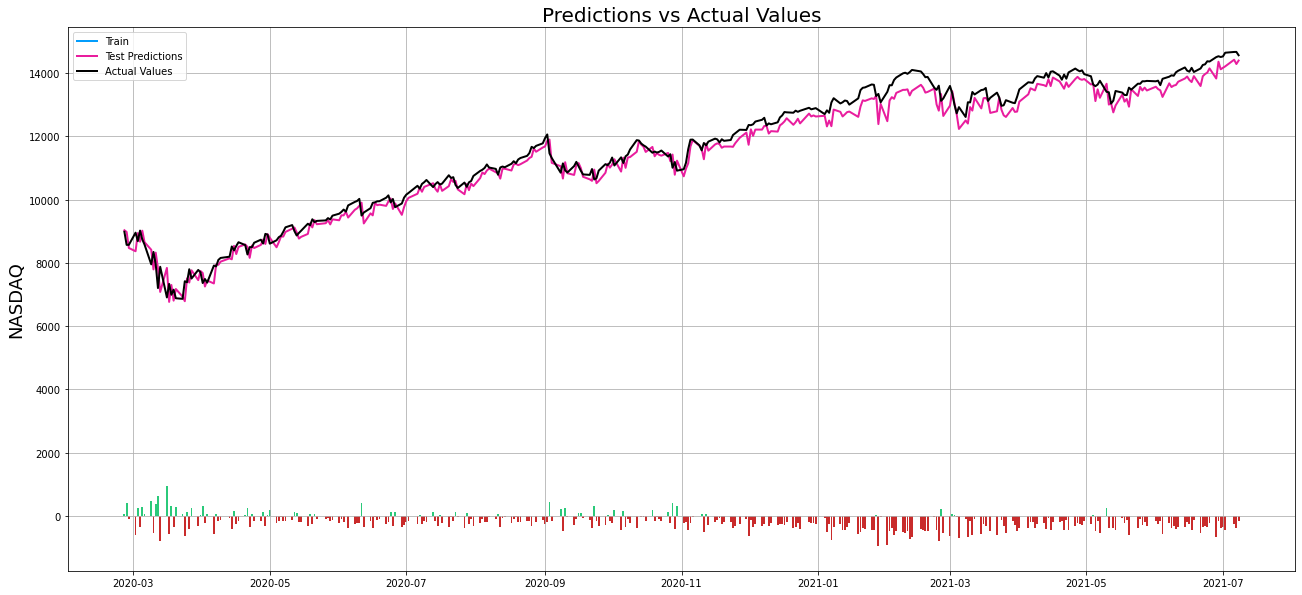

In [41]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

# Step #6 Predict Next Day's Price

In [42]:
# Get fresh data until today and create a new dataframe with only the price data
#date_start = date.today() - timedelta(days=50)
new_df = df[-sequence_length:] #webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
#d = pd.to_datetime(new_df.index)
# new_df['Month'] = d.strftime("%m") 
# new_df['Year'] = d.strftime("%Y") 
new_df = new_df.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close price for NASDAQ at 2021-07-09 was 14559.78
The predicted close price is 14072.830078125 (-3.46%)
